In [483]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## PARAMETERS :

In [484]:
# Simulation :
m_MC = 100 # Number of simulations
T = 50 # Time horizon in years
N = 50 # Number of time steps (daily frequency)
dt = T / N # Time step
initial_population = 10000  # Initial population size (number of contracts at t=0)


# Fund / Premium :
F0 = 100000 # Initial value of the fund / Premium Invested
sigma_equity = 0.20 # Volatility for equity
sigma_property = 0.10 # Volatility for property
PR_weight = 0.2 # Weight of PR in the portfolio
EQ_weight = 0.8 # Weight of EQ in the portfolio

# Liabilities :
RFR = 0.03
rd_rate = 0.022
COMM = 0.014
inflation_rate = 0.02
lapse_rate = 0.15  # Annual lapse rate
cst_cost = 50 # Constant unitary cost

In [485]:
# Generate the 50€ vector following the inflation :
Expenses = np.zeros(N)
Expenses[1:] = [cst_cost * (1 + inflation_rate) ** i for i in range(1,N)]
Expenses

array([  0.        ,  51.        ,  52.02      ,  53.0604    ,
        54.121608  ,  55.20404016,  56.30812096,  57.43428338,
        58.58296905,  59.75462843,  60.949721  ,  62.16871542,
        63.41208973,  64.68033152,  65.97393815,  67.29341692,
        68.63928525,  70.01207096,  71.41231238,  72.84055863,
        74.2973698 ,  75.78331719,  77.29898354,  78.84496321,
        80.42186247,  82.03029972,  83.67090572,  85.34432383,
        87.05121031,  88.79223451,  90.56807921,  92.37944079,
        94.22702961,  96.1115702 ,  98.0338016 ,  99.99447763,
       101.99436719, 104.03425453, 106.11493962, 108.23723841,
       110.40198318, 112.61002284, 114.8622233 , 117.15946777,
       119.50265712, 121.89271027, 124.33056447, 126.81717576,
       129.35351927, 131.94058966])

## ASSETS :

### Import RFR no VA :

In [486]:
# Path to your Excel file
file_path = 'EIOPA_RFR_20240331_Term_Structures.xlsx'

# Read Excel file
df = pd.read_excel(file_path, "RFR_spot_no_VA", usecols="C", )
df = df[9:]
df = df.rename(columns={'Unnamed: 18': 'EIOPA EU without VA, MAR'})
rt = np.array(df).T
rt = np.array(rt, np.float64)
rt = rt[0, :N] # Time-varying risk-free rate

### Simulate GBM :

In [487]:
def simulate_gbm_vec(F0, r, sigma, dt, N, m_MC):
    np.random.seed(123456)#1234)
    # Generate N samples from a GBM with risk-free rate r and volatility sigma
    # r and sigma are assumed to be annualized
    # dt is the time step
    # S0 is the initial value of the process
    S = np.zeros((m_MC, N))
    S[:, 0] = np.full(m_MC, F0)
    for t in range(1, N):
        # Generate m_MC samples of random normal variables
        z = np.random.normal(size=m_MC)
        # Update the stock price for all iterations simultaneously
        S[:, t] = S[:, t - 1] * np.exp((r[t] - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return S

(50, 100)(50, 100)


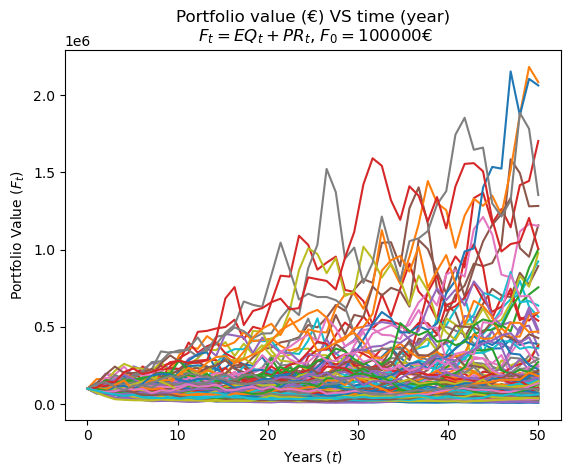

In [488]:
# Simulate equity and property paths
EQt= simulate_gbm_vec(F0, rt, sigma_equity, dt, N, m_MC)
PRt = simulate_gbm_vec(F0, rt, sigma_property, dt, N, m_MC)

# Calculate the fund value at each time step
fund_value = EQ_weight * EQt + PR_weight * PRt
F = np.squeeze(fund_value)

# Define time interval correctly
time = np.linspace(0,T,N)
# Require numpy array that is the same shape as F
tt = np.full(shape=(m_MC,N), fill_value=time).T
# Check that the dimensions are OK for the plot
print(str(tt.shape) + str(fund_value.T.shape))

plt.plot(tt, fund_value.T);
plt.xlabel("Years $(t)$")
plt.ylabel("Portfolio Value $(F_t)$")
plt.title("Portfolio value (€) VS time (year)\n $F_t = EQ_t + PR_t$, $F_0 = 100000€$")
plt.show()

## LIABILITIES :

### Create a dataframe with years, rates and discount factors :

In [489]:
EIOPA_yield_curve = pd.DataFrame()
EIOPA_yield_curve['Years'] = np.arange(0, 51, 1)
EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024'] = np.insert(rt, 0, 0)  # EIOPA RFR spot rate no VA, with 0 at year = 0 so that discount = 1
EIOPA_yield_curve['Discount Factors'] = 1 / (1 + EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024']) ** EIOPA_yield_curve['Years']
EIOPA_yield_curve

,Years,"EIOPA EU without VA, MARCH 2024",Discount Factors
0,0,0.00000,1.000000
1,1,0.03514,0.966053
2,2,0.03035,0.941956
3,3,0.02783,0.920950
4,4,0.02637,0.901123
5,5,0.02549,0.881745
6,6,0.02502,0.862196
7,7,0.02477,0.842588
8,8,0.02466,0.822928
9,9,0.02464,0.803264


### Import Life Table ISTATS :

In [490]:
df_LT = pd.read_excel("LT_M_only.xlsx", skiprows=[0], index_col=0)
df_LT

,Survivors lx,Deaths dx,Probability of death (per thousand) qx,Years lived Lx,Projection probability Px,Life expectancy ex,Info
Age x,,,,,,,
0,100000,249,2.49291,99765,0.999755,80.590,NaN
1,99751,20,0.19564,99741,0.999832,79.790,NaN
2,99731,14,0.14114,99724,0.999876,78.805,NaN
3,99717,11,0.10689,99712,0.999903,77.816,NaN
4,99706,9,0.08633,99702,0.999914,76.825,NaN
...,...,...,...,...,...,...,...
115,0,0,877.05602,0,0.121277,0.638,NaN
116,0,0,892.27829,0,0.106441,0.619,NaN
117,0,0,905.45023,0,0.093581,0.603,NaN


### Create a clean dataframe with the useful data from the life table :

In [491]:
Life_table = pd.DataFrame()
Life_table['Age'] = np.arange(60, 120, 1)
Life_table['Death probability qx'] = np.array(df_LT['Probability of death (per thousand)  qx'][60:120]) / 1000
Life_table['Cumulative survival probability px'] = (1 - Life_table['Death probability qx']).cumprod()
Life_table

,Age,Death probability qx,Cumulative survival probability px
0,60,0.006468,9.935321e-01
1,61,0.007100,9.864778e-01
2,62,0.007815,9.787684e-01
3,63,0.008665,9.702875e-01
4,64,0.009653,9.609216e-01
5,65,0.010795,9.505482e-01
6,66,0.011728,9.393999e-01
7,67,0.012798,9.273775e-01
8,68,0.013975,9.144174e-01
9,69,0.015660,9.000976e-01


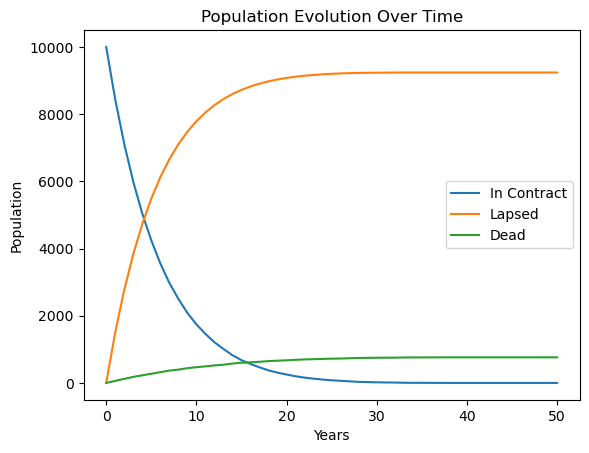

In [492]:
# Life table (taken from the real italian life table)
life_table = Life_table['Death probability qx']

# Initialize lists to store population data
population_in_contract = [initial_population]
population_lapsed = [0]
population_dead = [0]

# Simulate population evolution over 50 years
for year in range(1, N + 1):
    # Calculate number of deaths
    # deaths = np.random.binomial(population_in_contract[-1], life_table[min(year, max(life_table.keys()))])
    deaths = np.random.binomial(population_in_contract[-1], life_table[year - 1])

    # Calculate number of lapses
    lapses = int(population_in_contract[-1] * lapse_rate)

    # Update population
    population_in_contract.append(max(0, population_in_contract[-1] - deaths - lapses))
    population_lapsed.append(population_lapsed[-1] + lapses)
    population_dead.append(population_dead[-1] + deaths)

# Plot population evolution
years_range = range(N + 1)
plt.plot(years_range, population_in_contract, label='In Contract')
plt.plot(years_range, population_lapsed, label='Lapsed')
plt.plot(years_range, population_dead, label='Dead')
plt.xlabel('Years')
plt.ylabel('Population')
plt.title('Population Evolution Over Time')
plt.legend()
plt.show()


### Computation of the lapse liabilities :

Here in the MC, the "randomness" comes from $(F_t)_t$ : since in case of lapse, the beneficiary gets the value of the fund at the time of lapse, with 20 euros of penalties applied, the lapse liabilities obviously depend on the value of the fund. So we can simulate a vast number of funds at 50 years horizon and then compute (the same vast number of times) the lapse liabilities and finally take the average (expectation).

#### Get the data from the ISTATS life table and the EIOPA term structure :

In [493]:
px_cumul = Life_table["Cumulative survival probability px"]
discount_factors = EIOPA_yield_curve["Discount Factors"][:-1]

In [494]:
def lapse_proba(px_cumul, lapse_rate):
    """
    Calculate the lapse probability for each period based on the cumulative survival probability and lapse rate.

    Parameters:
    px_cumul (array-like): Array of cumulative survival probabilities.
    lapse_rate (float): Lapse rate for the insurance policy.

    Returns:
    array-like: Array of lapse probabilities for each period.
    """
    # lapse_p = np.array([px_cumul[i - 1] * (1 - lapse_rate) ** i * lapse_rate for i in range(len(px_cumul))])
    lapse_p = np.zeros(px_cumul.shape)

    for i in range(1, len(px_cumul)):
        lapse_p[i] = px_cumul[i - 1] * (1 - lapse_rate) ** (i - 1) * lapse_rate
    return lapse_p

def lapse_what_do_you_get(Ft, discount_factors):
    """
    Calculate the discounted (present) value of future cash flows based on the discount factors and what you get when you lapse.

    Parameters:
    Ft (array-like): Array of future cash flows.
    discount_factors (array-like): Array of discount factors.

    Returns:
    array-like: Array of present values of future cash flows.
    """
    DPV = (Ft - 20) * discount_factors
    DPV[0] = 0
    return DPV

def lapse_liabilities(RD, lapse_proba, lapse_what_do_you_get):
    """
    Calculate the lapse liabilities i.e. the net present value of future cash flows that will be paid to the policyholders who lapse.
    i.e. the expected value of the discounted cash flows that will be paid to the policyholders who lapse.

    Returns:
    array-like: Array of lapse liabilities.
    """
    return (1 - RD) * lapse_proba * lapse_what_do_you_get

def MC_lapse_liabilities(m_MC, F, discount_factors, px_cumul, lapse_rate, RD):
    """
    Calculate the lapse liabilities using Monte Carlo simulation.

    Parameters:
    m_MC (int): Number of Monte Carlo simulations.
    Ft (array-like): Array of future cash flows.
    discount_factors (array-like): Array of discount factors.
    px_cumul (array-like): Array of cumulative survival probabilities.
    lapse_rate (float): Lapse rate for the insurance policy.
    RD (float): Residual death benefit.

    Returns:
    array-like: Array of lapse liabilities.
    """
    # Calculate lapse probabilities
    lapse_p = lapse_proba(px_cumul, lapse_rate)

    sum = 0

    for m in range(m_MC):
        # Calculate what you get when you lapse
        lapse_what_you_get = lapse_what_do_you_get(F[m], discount_factors)

        # Calculate lapse liabilities
        lapse_liab = lapse_liabilities(RD, lapse_p, lapse_what_you_get)
        sum += lapse_liab

    # Calculate the lapse liabilities using Monte Carlo simulation
    lapse_liab_MC = sum / m_MC
    return np.array(lapse_liab_MC)

#### Example for the lapse liability :

In [495]:
# MC :
MC_liab = MC_lapse_liabilities(m_MC, F, discount_factors, px_cumul[:50], lapse_rate, rd_rate)
MC_liab

array([0.00000000e+00, 1.39651758e+04, 1.21204556e+04, 1.03167150e+04,
       8.53852074e+03, 7.07000271e+03, 5.80792119e+03, 4.88820323e+03,
       4.11780963e+03, 3.53856437e+03, 2.94655951e+03, 2.58325392e+03,
       2.14952973e+03, 1.75289631e+03, 1.45582688e+03, 1.22906228e+03,
       9.98478409e+02, 7.87124984e+02, 6.46550067e+02, 5.44726667e+02,
       4.45269643e+02, 3.59118507e+02, 2.89874260e+02, 2.26454140e+02,
       1.89352622e+02, 1.44668935e+02, 1.13454117e+02, 8.44643536e+01,
       6.03125299e+01, 4.40610103e+01, 3.11903284e+01, 2.14975818e+01,
       1.51937926e+01, 9.53746636e+00, 5.83643068e+00, 3.66090902e+00,
       2.25127545e+00, 1.24500052e+00, 6.65491122e-01, 3.48098852e-01,
       1.78350326e-01, 8.54557875e-02, 3.96138905e-02, 1.63450093e-02,
       5.83385017e-03, 2.00494079e-03, 6.90834087e-04, 2.08042906e-04,
       5.68254797e-05, 1.35115001e-05])

In [496]:
MC_liab.sum()

87506.16201837061

In [497]:
proba = lapse_proba(px_cumul, 0.15)
proba = proba[:50]
what = lapse_what_do_you_get(F[0], discount_factors)
# liab = lapse_liabilities(0.022, proba, what)

Lapse = pd.DataFrame()
Lapse["Proba Lapse"] = proba
Lapse["Discounted Present Value of the Lapse Cash Flows"] = what
Lapse["Lapse Liabilities"] = MC_liab
Lapse.head()

,Proba Lapse,Discounted Present Value of the Lapse Cash Flows,Lapse Liabilities
0,0.000000,0.000000,0.000000
1,0.149030,106518.991543,13965.175778
2,0.125776,98658.452014,12120.455566
3,0.106074,73716.751185,10316.714978
4,0.089382,59925.680079,8538.520738


Not working :

In [498]:
# Here we can do a MC simulation also on the population to see if we have kind of the same result :

def forward_diff(arr):
    """
    Compute the forward difference of an array.
    Example :
    arr = [1, 3, 6, 10, 15]
    result = forward_diff(arr)
    print("Forward difference:", result)
    [2, 3, 4, 5]
    """
    arr = np.asarray(arr)  # Convert input to NumPy array
    forward_diff = arr[1:] - arr[:-1]  # Compute forward difference
    return forward_diff

def lapse(array_of_diff, F, discount_factors, T, RD):
    lapses = np.zeros(T)
    for t in range(T):
        lapses[t] = discount_factors[t] * array_of_diff[t] * (F[t] - 20)
    return (1 - RD) * lapses

def MC_lapse(m_MC, rd_rate, discount_factors, T, F, population_lapsed):
    lapses = np.zeros((m_MC, T))
    for i in range(m_MC):
        diff = forward_diff(population_lapsed)
        lapses[i] = lapse(diff, F[i], discount_factors, T, rd_rate)
    return lapses, np.sum(lapses, axis=0)

### Computation of the death liabilities :

Here in the MC, the "randomness" comes from $(F_t)_t$ : since in case of death, the beneficiary gets the maximum between the invested premium and the value of the fund, the death liabilities obviously depend on the value of the fund. So we can simulate a vast number of funds at 50 years horizon and then compute (the same vast number of times) the death liabilities and finally take the average (expectation).

#### Get the data from the ISTATS life table and the EIOPA term structure :

In [499]:
qx = Life_table["Death probability qx"]

In [500]:
def death_proba(px_cumul, lapse_rate, qx):
    """
    """
    death_p = np.zeros(px_cumul.shape)
    for k in range(1, len(px_cumul)):
        if k == 1:
            death_p[k] = 1 * (1 - lapse_rate) ** (k - 1) * qx[k - 1]
        else:
            death_p[k] = px_cumul[k - 2] * (1 - lapse_rate) ** (k - 1) * qx[k - 1]
    return death_p

def death_what_do_you_get(Ft, discount_factors, C0):
    """
    Compute the maximum between the invested premium and the value of the fund.
    """
    DPV = np.array([max(C0, value) for value in Ft]) * discount_factors
    DPV[0] = 0
    return DPV

def death_liabilities(RD, death_proba, death_what_do_you_get):
    """
    """
    return (1 - RD) * death_proba * death_what_do_you_get

def MC_death_liabilities(m_MC, F, discount_factors, px_cumul, lapse_rate, RD):
    """
    Calculate the death liabilities using Monte Carlo simulation.
    """
    # Calculate death probabilities
    death_p = death_proba(px_cumul, lapse_rate, life_table)

    sum = 0

    for m in range(m_MC):
        # Calculate what you get when you die
        death_what_you_get = death_what_do_you_get(F[m], discount_factors, F0)

        # Calculate death liabilities
        death_liab = death_liabilities(RD, death_p, death_what_you_get)
        sum += death_liab
    
    # Calculate the death liabilities using Monte Carlo simulation
    death_liab_MC = sum / m_MC
    return np.array(death_liab_MC)

#### Example from the death liability :

In [501]:
# MC :
d_MC_liab = MC_death_liabilities(m_MC, F, discount_factors, px_cumul[:50], lapse_rate, rd_rate)
d_MC_liab

array([0.00000000e+00, 6.54394589e+02, 6.24367197e+02, 5.94038028e+02,
       5.54908818e+02, 5.16575911e+02, 4.83363367e+02, 4.40860452e+02,
       4.01290554e+02, 3.74204048e+02, 3.54634547e+02, 3.44295582e+02,
       3.23272867e+02, 2.91807387e+02, 2.65836678e+02, 2.43776473e+02,
       2.23152498e+02, 2.00717098e+02, 1.88184683e+02, 1.75346403e+02,
       1.62111134e+02, 1.47842884e+02, 1.34218921e+02, 1.18108934e+02,
       1.08267987e+02, 9.41109923e+01, 8.52302523e+01, 7.41767411e+01,
       6.13614225e+01, 5.20578784e+01, 4.31240082e+01, 3.43257483e+01,
       2.72912937e+01, 1.98846759e+01, 1.36844305e+01, 9.97708956e+00,
       7.03528196e+00, 4.42154042e+00, 2.63002211e+00, 1.51013170e+00,
       8.50815943e-01, 4.62958829e-01, 2.51807895e-01, 1.19267931e-01,
       4.90117371e-02, 1.93791191e-02, 7.67106843e-03, 2.66736949e-03,
       8.40261892e-04, 2.32082963e-04])

In [502]:
d_MC_liab.sum()

8458.163202732783

In [503]:
d_proba = death_proba(px_cumul, 0.15, qx)
d_proba = d_proba[:50]
d_what = death_what_do_you_get(F[0], discount_factors, F0)

Death = pd.DataFrame()
Death["Proba Death"] = d_proba
Death["Discounted Present Value of the Death Cash Flows"] = d_what
Death["Death Liabilities"] = d_MC_liab
Death.head()

,Proba Death,Discounted Present Value of the Death Cash Flows,Death Liabilities
0,0.000000,0.000000,0.000000
1,0.006468,106538.312601,654.394589
2,0.005996,98677.291127,624.367197
3,0.005570,92095.016751,594.038028
4,0.005208,90112.326459,554.908818


### Computation of the lapse and death commission liabilities :

In [504]:
def L_and_D_COMM_Liabilities(d_proba, l_proba, d_DPV, l_DPV, COMM):
    d_COMM_liabilities = d_proba * d_DPV * COMM
    l_COMM_liabilities = l_proba * l_DPV * COMM
    return np.array(d_COMM_liabilities), np.array(l_COMM_liabilities)

In [505]:
b = L_and_D_COMM_Liabilities(d_proba, proba, d_what, what, COMM)
b[0].sum() + b[1].sum()

1105.9185107245496

In [506]:
def L_and_D_COMM_Liabilities_MC(m_MC, COMM, N):
    """
    Calculate the commission liabilities for death and lapse using Monte Carlo simulation.
    """
    # Calculate death probabilities
    death_p = death_proba(px_cumul, lapse_rate, life_table)[:N]
    # Calculate lapse probabilities
    lapse_p = lapse_proba(px_cumul, lapse_rate)[:N]

    sum = 0

    for m in range(m_MC):
        # Calculate what you get when you die
        death_what_you_get = death_what_do_you_get(F[m], discount_factors, F0)
        # Calculate what you get when you lapse
        lapse_what_you_get = lapse_what_do_you_get(F[m], discount_factors)

        # Calculate L and D commission liabilities
        L_and_D_COMM_Liab = L_and_D_COMM_Liabilities(death_p, lapse_p, death_what_you_get, lapse_what_you_get, COMM)
        sum += L_and_D_COMM_Liab[0] + L_and_D_COMM_Liab[1]
    
    # Calculate the COMM liabilities using Monte Carlo simulation
    COMM_Liab_MC = sum / m_MC
    return np.array(COMM_Liab_MC)

In [507]:
L_n_D_COMM_liab = L_and_D_COMM_Liabilities_MC(m_MC, COMM, N)
L_n_D_COMM_liab.sum()

1373.7224469278603

### Computation of the expenses liabilities :

In [508]:
def Expenses_liabilities(Expenses, discount_factors, lapse_rate, px_cumul, N):
    Expenses_liab = np.zeros(N)
    Expenses_liab[1] = Expenses[1] * discount_factors[1] * 1 * 1 # (1 - lapse_rate) ** 0 = 1 and px_cumul = 1 at zeroth year
    for i in range(2, N):
        Expenses_liab[i] = Expenses[i] * discount_factors[i] * (1 - lapse_rate) ** (i - 1) * px_cumul[i - 2]
    return Expenses_liab

In [509]:
Exp_liab = Expenses_liabilities(Expenses, discount_factors, lapse_rate, px_cumul, N)
Exp_liab.sum()

300.9282630486166

### Creation of a liabilities dataframe :

In [510]:
def liabilities_summary(lapse_liab, death_liab, comm_liab, exp_liab, N):
    summary = pd.DataFrame()
    summary["Years"] = np.arange(0, N, 1)
    summary["Lapse"] = lapse_liab
    summary["Death"] = death_liab
    summary["COMM"] = comm_liab
    summary["Expenses"] = exp_liab
    summary["Total per year"] = lapse_liab + death_liab + comm_liab + exp_liab
    return summary

In [518]:
summary = liabilities_summary(MC_liab, d_MC_liab, L_n_D_COMM_liab, Exp_liab, N)
summary

,Years,Lapse,Death,COMM,Expenses,Total per year
0,0,0.000000,0.000000,0.000000,0.000000e+00,0.000000
1,1,13965.175778,654.394589,209.278103,4.926870e+01,14878.117169
2,2,12120.455566,624.367197,182.441226,4.138106e+01,12968.645051
3,3,10316.714978,594.038028,156.186648,3.482826e+01,11101.767918
4,4,8538.520738,554.908818,130.171793,2.931511e+01,9252.916463
5,5,7070.002707,516.575911,108.601330,2.465414e+01,7719.834087
6,6,5807.921187,483.363367,90.059288,2.069949e+01,6402.043328
7,7,4888.203232,440.860452,76.285165,1.734898e+01,5422.697834
8,8,4117.809632,401.290554,64.690596,1.451831e+01,4598.309093
9,9,3538.564367,374.204048,56.011000,1.212936e+01,3980.908771


In [512]:
TOT_Liabilities = summary["Total per year"].sum()
TOT_Liabilities

97638.97593107988

In [513]:
BOF = F0 - TOT_Liabilities # a corriger !
BOF

2361.0240689201164

### Not modified yet :

In [514]:
def death(array_of_diff, F, discount_factors, T):
    deaths = np.zeros(T)
    for t in range(T):
        deaths[t] = discount_factors[t] * array_of_diff[t] * np.maximum(F[t], 100000)
    return deaths

def regular_deduction(array_of_alive, F, rd_rate, discount_factors, T):
    r_deductions = np.zeros(T)
    for t in range(T):
        r_deductions[t] = discount_factors[t] * array_of_alive[t] * rd_rate * (F[t] - 20)
    return r_deductions

def COMM(array_of_alive, F, comm_rate, discount_factors, T):
    comms = np.zeros(T)
    for t in range(T):
        comms[t] = discount_factors[t] * array_of_alive[t] * comm_rate * F[t]
    return comms

def expense(array_of_alive, inflation_rate, discount_factors, T):
    expenses = np.zeros(T)
    base_expenses = np.array([50 * (1 + inflation_rate) ** i for i in range(T)])
    for t in range(T):
        expenses[t] = discount_factors[t] * array_of_alive[t] * base_expenses[t] 
    return expenses

def liabilities_through_t(lapses, deaths, r_deductions, comms, expenses):
    liabilities = lapses + deaths - r_deductions + comms + expenses
    return liabilities

def discount_factor(RFR, T):
    v = 1 / (1 + RFR)
    discount_factors = np.array([v ** i for i in range(T)])
    return discount_factors

def RUN(population_in_contract, population_lapsed, population_dead, RFR, T, F, rd_rate, comm_rate, inflation_rate):
    discount_factors = discount_factor(RFR, T)

    lapse_diff = forward_diff(population_lapsed)
    lapses = lapse(lapse_diff, F, discount_factors, T)

    death_diff = forward_diff(population_dead)
    deaths = death(death_diff, F, discount_factors, T)

    r_deductions = regular_deduction(population_in_contract, F, rd_rate, discount_factors, T)

    comms = COMM(population_in_contract, F, comm_rate, discount_factors, T)

    expenses = expense(population_in_contract, inflation_rate, discount_factors, T)

    liabilities = liabilities_through_t(lapses, deaths, r_deductions, comms, expenses)
    return liabilities

In [515]:
def RUN_MC(m_MC, population_in_contract, population_lapsed, population_dead, RFR, T, rd_rate, comm_rate, inflation_rate, F0, rt, sigma_equity, dt, N):
    # Simulate equity and property paths
    EQt= simulate_gbm_vec(F0, rt, sigma_equity, dt, N, m_MC)
    PRt = simulate_gbm_vec(F0, rt, sigma_property, dt, N, m_MC)
    # Calculate the fund value at each time step
    F = EQ_weight * EQt + PR_weight * PRt

    MC = np.zeros(F.shape)

    for sim in range(F.shape[0]):
        FF = F[sim, :]
        MC[sim, :] = RUN(population_in_contract, population_lapsed, population_dead, RFR, T, FF, rd_rate, comm_rate, inflation_rate)
    
    BOF = N * F - MC
    
    return MC, BOF

In [516]:
MC_TOT, BOF = RUN_MC(m_MC, population_in_contract, population_lapsed, population_dead, RFR, T, rd_rate, comm_rate, inflation_rate, F0, rt, sigma_equity, dt, N)
MC_TOT.shape, BOF.shape

TypeError: lapse() missing 1 required positional argument: 'RD'

(50, 100)(50, 100)


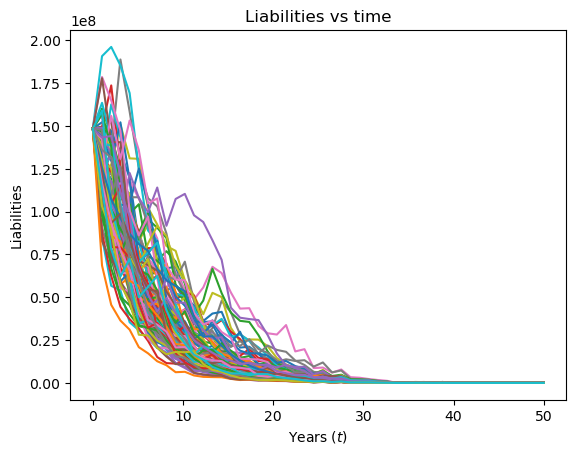

In [ ]:
# Define time interval correctly
time = np.linspace(0,T,N)
# Require numpy array that is the same shape as F
tt = np.full(shape=(m_MC,N), fill_value=time).T
# Check that the dimensions are OK for the plot
print(str(tt.shape) + str(MC_TOT.T.shape))

plt.plot(tt, MC_TOT.T);
plt.xlabel("Years $(t)$")
plt.ylabel("Liabilities")
plt.title("Liabilities vs time")
plt.show()

(50, 100)(50, 100)


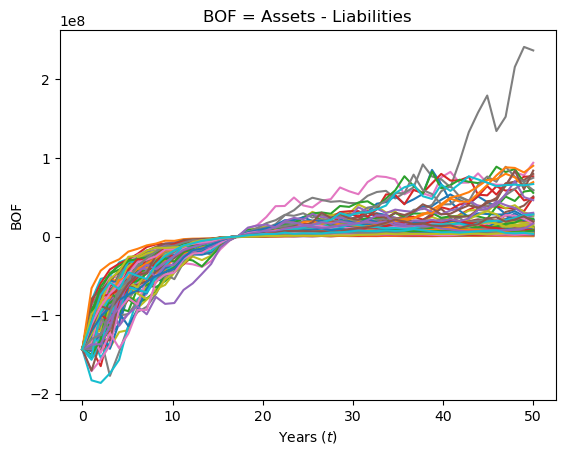

In [ ]:
# Define time interval correctly
time = np.linspace(0,T,N)
# Require numpy array that is the same shape as F
tt = np.full(shape=(m_MC,N), fill_value=time).T
# Check that the dimensions are OK for the plot
print(str(tt.shape) + str(BOF.T.shape))

plt.plot(tt, BOF.T);
plt.xlabel("Years $(t)$")
plt.ylabel("BOF")
plt.title("BOF = Assets - Liabilities")
plt.show()

In [ ]:
def build_coefficient_array(arr):
    n = len(arr)
    coefficient_array = [0] * n

    for i in range(n):
        for j in range(n - i):
            coefficient_array[i] += arr[n - j - 1]

    return coefficient_array

# Example usage:
arr = [1, 2, 3, 4, 5]
result = build_coefficient_array(arr)
print(result)

[15, 14, 12, 9, 5]


In [ ]:
bof = BOF[0]
aa = build_coefficient_array(bof)

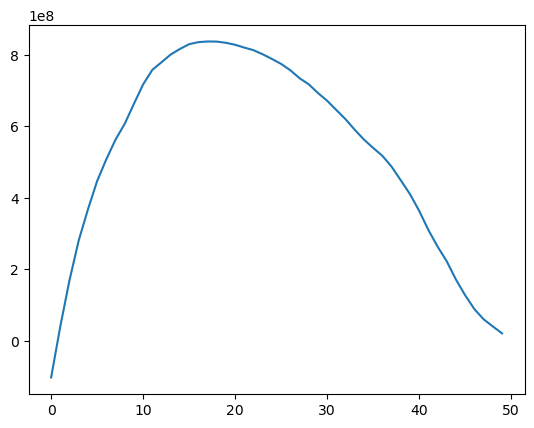

In [ ]:
plt.plot(aa);

## Stress :

In [532]:
# IR up :
# Path to your Excel file
file_path = 'EIOPA_RFR_20240331_Term_Structures.xlsx'

# Read Excel file
df = pd.read_excel(file_path, "Spot_NO_VA_shock_UP", usecols="C", )
df = df[11:]
df = df.rename(columns={'Unnamed: 2': 'EIOPA EU without VA, MAR'})
rt_up = np.array(df).T
rt_up = np.array(rt_up, np.float64)
rt_up = rt_up[0, :N] # Time-varying risk-free rate

In [533]:
df

,Unnamed: 3
11,0.01
12,0.01
13,0.01
14,0.01
15,0.01
...,...
154,0.01
155,0.01
156,0.01
157,0.01


In [534]:
rt_up

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01])